In [2]:
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
impute = True

In [4]:
raw_train = pd.read_csv("../../data/train.csv", parse_dates=['timestamp'],index_col="id")
raw_test = pd.read_csv("../../data/test.csv", parse_dates=['timestamp'],index_col="id")
locales = pd.read_csv("../data/okurg_chase.csv")

In [5]:
# test = pd.read_csv("../data/clean_test_only_complete_cols_chase.csv", parse_dates=['timestamp'],index_col="id")
# test_cols = test.columns.tolist()

# find columns that are not in clean test
# drop_cols = []
# for col in raw_train.columns:
#     if col not in test_cols:
#         drop_cols.append(col)

# # remove price_doc
# drop_cols.pop()

In [6]:
# top fields from Grant's xgb
fields = ['timestamp','price_doc','kremlin_km','full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 
          'num_room', 'state','material','sub_area']
bad_ids = [2121,20247,17586,26362]

In [7]:
all_cols = True

In [8]:
if all_cols:
    df = raw_train.copy()
    test = raw_test.loc[:,fields]
else:
    df = raw_train.loc[:,fields]
    test = raw_test.loc[:,fields]


df = pd.merge(df,locales, how="left", on="sub_area").reset_index(drop=True).set_index(df.index)
df.drop(bad_ids,axis=0,inplace=True)

## Thoughts
* outliers?
    df[df.life_to_full<.25]
    

# Missingness Overview

In [9]:
print "shape of data {}".format(df.shape)
missing = df.isnull()
print "num cols missing {}".format(sum(missing.any(axis=0)))
print "num rows missing {}".format(sum(missing.any(axis=1)))
print "rows with missing {:.2f}%".format(100. * sum(missing.any(axis=1))/len(df))
print "\n"
cols = ['full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'state','sub_area']
for col in cols:
    print "number of missing {} {}".format(col,sum(df[col].isnull()))

shape of data (30467, 293)
num cols missing 51
num rows missing 24426
rows with missing 80.17%


number of missing full_sq 0
number of missing life_sq 6383
number of missing kitch_sq 9571
number of missing floor 167
number of missing max_floor 9571
number of missing build_year 13604
number of missing num_room 9571
number of missing state 13558
number of missing sub_area 0


### Helper Functions

In [10]:
def add_multiples(df):
    """ add/update price multiples and sq ratios. This is just for finding outliers """
    
    # create the columns for price / sq
    price_to_full = df.price_doc / df.full_sq
    df.loc[:,'price_full'] = price_to_full
    df.loc[:,'price_full_std'] = (price_to_full - np.nanmean(price_to_full)) / np.nanstd(price_to_full)

def getKremlinGroup(df, id):
    """ returns the group that are the same distance from the kremlin"""
    x = df.loc[id,'kremlin_km']
    return df.loc[df.kremlin_km==x,:]

def getKremlinGroupFloor(df, id):
    """ returns the group that are the same distance from the kremlin"""
    target_max_floor = df.loc[id,'max_floor']
    
    x = df.loc[id,'kremlin_km']
    comps = df.loc[df.kremlin_km==x,:]
    build_year = np.nanmedian(comps.loc[(comps.max_floor == target_max_floor),'build_year'])
    if build_year == np.nan:
        build_year = np.nanmedian(comps.build_year)
    return build_year
    

In [11]:
add_multiples(df)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1304: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


In [12]:
# Dropping all price multiples that are less way less than the median price/sq for russia ~150k

In [13]:
df.drop(df[df.price_full<30000].index,axis=0,inplace=True)

## Initial changes
Drop some initial outliers
    * full_sq < 10 set to nan
    * life > full both to nan
    * kitch > full both to nan
    * kitch > life both to nan
    * kitch > 200 to nan
    * floor == 0 to nan
    * max_floor == 0 to nan
    * max_floor < floor to nan
    * build_year 
        * 1500 < build_year > 2018 to nan
    * num_room == 0 to nan

    

In [14]:
def printStats(test):
    print "number that full_sq > 450 : ", len(test[test.full_sq > 450])
    print "number that full_sq < 10 : ", len(test[test.full_sq < 10])
    print "number that full < life : ", len(test[test.full_sq < test.life_sq])
    print "number that full < kitch : ", len(test[test.full_sq < test.kitch_sq])
    print "number that life < kitch : ", len(test[test.life_sq < test.kitch_sq])
    print "number that kitch > 200 : ", len(test[test.kitch_sq > 200])
    print "number that kitch <= 1 : ", len(test[test.kitch_sq <= 1])

    print "number that floor == 0 : ", len(test[test.floor == 0])
    print "number that floor > 70 : ", len(test[test.floor > 70])
    print "number that max_floor > 70 : ", len(test[test.max_floor > 70])
    print "number that max_floor == 0 : ", len(test[test.max_floor == 0])
    print "number that max_floor < floor : ", len(test[test.max_floor < test.floor])
    print "number that num_room == 0 : ", len(test[test.num_room == 0])
    print "number that build_year <=1  : ", len(test[test.build_year <= 1])

In [15]:
print "Test data stats"
printStats(test)
print "\n"
print "Training data stats"
printStats(df)

Test data stats
number that full_sq > 450 :  0
number that full_sq < 10 :  3
number that full < life :  12
number that full < kitch :  5
number that life < kitch :  12
number that kitch > 200 :  2
number that kitch <= 1 :  2128
number that floor == 0 :  0
number that floor > 70 :  0
number that max_floor > 70 :  0
number that max_floor == 0 :  233
number that max_floor < floor :  643
number that num_room == 0 :  0
number that build_year <=1  :  556


Training data stats
number that full_sq > 450 :  0
number that full_sq < 10 :  29
number that full < life :  37
number that full < kitch :  12
number that life < kitch :  55
number that kitch > 200 :  5
number that kitch <= 1 :  6223
number that floor == 0 :  8
number that floor > 70 :  1
number that max_floor > 70 :  4
number that max_floor == 0 :  549
number that max_floor < floor :  1490
number that num_room == 0 :  14
number that build_year <=1  :  895


In [16]:
q = 'full_sq < 10 or full_sq < life_sq or full_sq < kitch_sq or life_sq < kitch_sq'

df.loc[df.query(q).index,['full_sq','life_sq','kitch_sq']] = np.nan

df.loc[df.floor == 0, 'floor'] = np.nan
df.loc[df.floor > 70, 'floor'] = np.nan

df.loc[df.full_sq > 450,'full_sq'] = np.nan
df.loc[df.life_sq <= 1, 'life_sq'] = np.nan
df.loc[df.kitch_sq <= 1, 'kitch_sq'] = np.nan

df.loc[df.max_floor > 70, 'max_floor'] = np.nan
df.loc[df.max_floor == 0, 'max_floor'] = np.nan

df.loc[df.num_room == 0, 'num_room'] = np.nan

bad_sq = df[df[['full_sq','life_sq','kitch_sq']].isnull().all(axis=1)]
print "number of missing sq rows ", len(bad_sq)

# some of the years are screwed up
if impute:
    df.loc[df.build_year < 1875, 'build_year'] = 1875 # 1875 is the oldest in the test
#     df.loc[df.build_year==1, 'build_year'] = 2001
    df.loc[df.build_year==3, 'build_year'] = 2003
    df.loc[df.build_year==20, 'build_year'] = 2000
    df.loc[df.build_year==71, 'build_year'] = 1971
    df.loc[df.build_year==215, 'build_year'] = 2015
    df.loc[15223,'build_year'] = 1965
    df.loc[10092,'build_year'] = 2005
    df.loc[10093,'build_year'] = 2009
    
else:
    df.loc[(df.build_year<1500) | (df.build_year>2018),'build_year'] = np.nan

number of missing sq rows  114


### Initial drops

In [17]:
# no years in the test before 1875
df.drop(df[df.build_year<1875].index, axis=0, inplace=True)

# no sq data
df.drop(bad_sq.index,axis=0, inplace=True)


In [18]:
printStats(df)

number that full_sq > 450 :  0
number that full_sq < 10 :  0
number that full < life :  0
number that full < kitch :  0
number that life < kitch :  0
number that kitch > 200 :  0
number that kitch <= 1 :  0
number that floor == 0 :  0
number that floor > 70 :  0
number that max_floor > 70 :  0
number that max_floor == 0 :  0
number that max_floor < floor :  936
number that num_room == 0 :  0
number that build_year <=1  :  0


## FLOORS & MAX FLOOR

I think for the columns that floor > max_floor and the max_floor is not 1 or 0, the columns are actually reversed.
The number of 1 0s show up more in the same region that has the majority of 1 and 0s. I think this region just has poor reporting and uses 1 or 0 as missing.


#### Floor > Max_Floor and Max_floor > 1
Switch the columns

#### Remaining Max_floor
impute using KNN


### Max vs Floor
when floor > max_floor. I think the 

Looks like the distribution of floors is off in the missing data. I think the columns are acutally switched.
Like the rows with messed up sq feet, there are a lot of 1s and 0s that come from the Novomoskovsky region.
I think the 0s and 1s are nan here too

In [19]:
missing = df[(df.floor>df.max_floor)]
missing = missing.drop(['timestamp','sub_area','okurg_district','price_doc'],axis=1)

left Floor distribution of questionable ones, floor>max and floor > 1
right floor distribution for floor < max and floor > 1


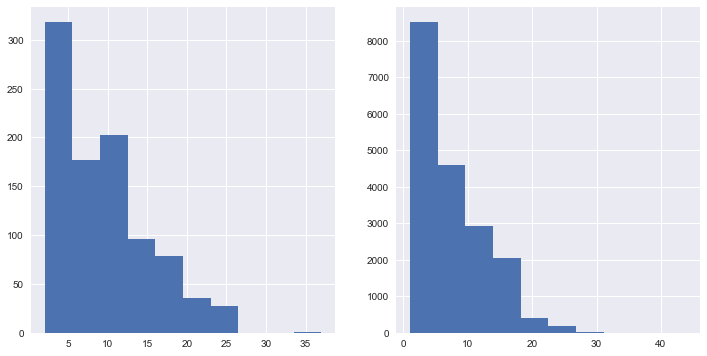

In [20]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
missing.floor.hist(ax=axs[0])
print "left Floor distribution of questionable ones, floor>max and floor > 1"
print "right floor distribution for floor < max and floor > 1"
df[(df.max_floor>=df.floor)].floor.hist(ax=axs[1])

left: max_floor distribution of the questionable data, floor > max_floor 
right: max_floor distribution of good data, floor < max


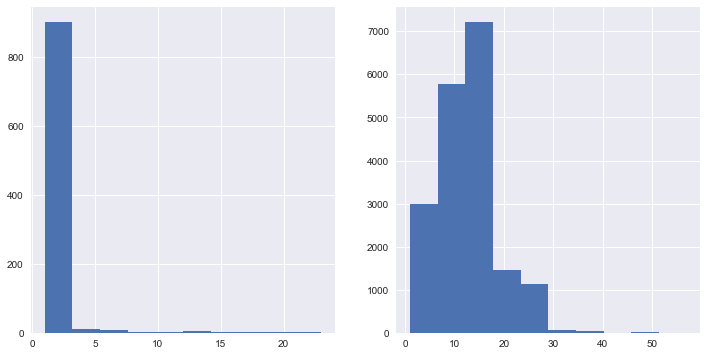

In [21]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
missing.max_floor.hist(ax=axs[0])
print "left: max_floor distribution of the questionable data, floor > max_floor "
print "right: max_floor distribution of good data, floor < max"
df[(df.max_floor>=df.floor)].max_floor.hist(ax=axs[1])

In [22]:
dfg = df[df.max_floor>=df.floor].groupby('kremlin_km')    
# missing is the columns where floor > max and max_floor > 0
# max_floor = 1 or 0, the thought 
for x in missing.iterrows():
    try:
        k = x[1].kremlin_km
        group = dfg.get_group(k)
        group = group[group.floor<group.max_floor]
        max_floors = group.max_floor.tolist()
        floors = group.floor.tolist()
        x[1].floor_count_in_grp_max = max_floors.count(x[1].floor)
        x[1].max_floor_count_grp_max = max_floors.count(x[1].max_floor)
        x[1].floor_count_grp_floor = floors.count(x[1].floor)
    except:
        pass

### Floor count frequency in the complete data
Want to see how often the questionable floors [floor > max_floor] show up in the good dataset [floor < max_floor]

In [23]:
temp = missing[['kremlin_km','floor','max_floor']].copy()

floors = df[df.floor<df.max_floor].floor.value_counts()

# frequency count of floors
floorsCounts = {k:v for k,v in zip(floors.index.tolist(),floors.tolist())}

# dictionary of the ratios
floorsRatios = {k:"%.2f" % (v*1./sum(floorsCounts.values())) for k,v in zip(floors.index.tolist(),floors.tolist())}

temp.loc[:,'floorFrequency'] = np.nan

temp.floorFrequency = temp.floor.apply(lambda x: floorsRatios[x])

In [24]:
temp[temp.floor>3].sort_values('floor',ascending=False).head(15)

,kremlin_km,floor,max_floor,floorFrequency
id,,,,
27499,9.145442,37.0,1.0,0.00
28445,20.549464,25.0,19.0,0.00
20596,14.989998,25.0,1.0,0.00
19310,13.310013,25.0,23.0,0.00
10795,18.752843,25.0,1.0,0.00
11367,18.752843,25.0,1.0,0.00
22228,23.373697,25.0,9.0,0.00
11687,17.948904,25.0,1.0,0.00
23892,14.998673,25.0,1.0,0.00


So it looks like the higher ones are definitely off, the problem is with the ones less than 5. <br>
Let's look at the distribution before and after reversing the columns

left is good data before the flip and right is after the flip, not real change


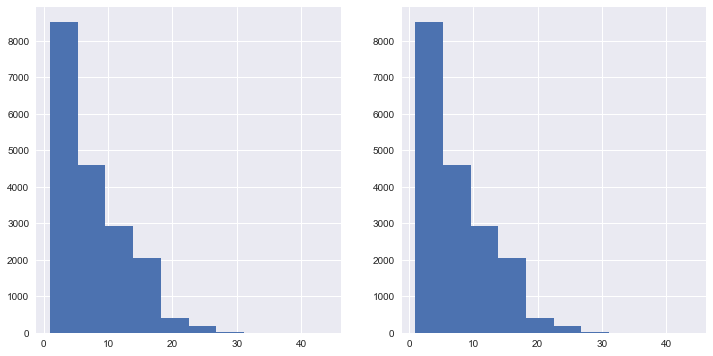

In [25]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
df[df.floor<=df.max_floor].floor.hist(ax=axs[0])
print "left is good data before the flip and right is after the flip, not real change"
temp = df.copy()
bad_index = temp[(temp.floor>temp.max_floor) & (temp.max_floor != 0)].index
new_floor = temp.loc[bad_index,'max_floor'].tolist()
new_max = temp.loc[bad_index,'floor'].tolist()
temp.loc[bad_index,'floor'] = new_floor
temp.loc[bad_index,'max_floor']= new_max

# distribution stays about the same after making this adjustment
temp[df.floor<=df.max_floor].floor.hist(ax=axs[1])

In [26]:
if impute:
    bad_floors = df[df.floor>df.max_floor].copy()
    indx = bad_floors.index

    # switching the floor columns 
    new_floor = df.loc[indx,'max_floor']
    new_max = df.loc[indx,'floor']
    
    bad_floors.loc[indx,'max_floor'] = new_max
    bad_floors.loc[indx, 'floor'] = new_floor
    df.loc[bad_floors.index,:] = bad_floors

else:
    bad_floors.loc[:,'max_floor'] = np.nan
# bad_floors.sort_values('max_floor')

In [27]:
len(raw_train)

30471

# Imputing Missing Floors

### KNN Regression first

Want to give more weight to neighborhood, so adding another kremlin variable

In [28]:
cols = ['price_doc','kremlin_km', 'full_sq', 'floor', 'max_floor']

complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()
complete['kremlin_km2'] = complete['kremlin_km']

missing = df.loc[df.max_floor.isnull(),cols].copy()
missing['kremlin_km2'] = missing['kremlin_km']
cols = ['price_doc','kremlin_km', 'full_sq', 'floor','kremlin_km2']

missing = missing.loc[~missing[cols].isnull().any(axis=1),:]
prediction_inputs = missing.drop('max_floor',axis=1).copy()

In [29]:
predictGroups = prediction_inputs.groupby('floor')

In [30]:
for p in predictGroups:
    c = complete[complete.max_floor > p[0]]
    n = len(c)
        
    neigh = KNeighborsRegressor(n_neighbors=min(2,n))
    missing.loc[p[1].index,'max_floor_KNNR2'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsRegressor(n_neighbors=min(5,n))
    missing.loc[p[1].index,'max_floor_KNNR5'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsRegressor(n_neighbors=min(100,n))
    missing.loc[p[1].index,'max_floor_KNNR100'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

### Trying KNN with everything as a category

Set all columns to category because I wanted to find try and match up the exact building from the group. Rounded the sq meters to the closest 5 to improve the odds of matching.

In [31]:
def roundIt(x, base=5):
    return int(base * round(float(x)/base))

In [32]:
cols = ['price_doc','kremlin_km', 'full_sq', 'floor','kremlin_km2']

# make the sq round so it's easier to match 
missing['full_sq'] = missing['full_sq'].apply(roundIt)
missing['price_doc'] = missing['price_doc'].apply(roundIt,base=10000)

## drop all rows with missing in anything except max_floor
prediction_inputs = missing[cols].apply(lambda x: x.astype('category'),axis=0)

predictGroups = prediction_inputs.groupby('floor')

for p in predictGroups:
    c = complete[complete.max_floor > p[0]]
    n = len(c)

    neigh = KNeighborsClassifier(n_neighbors=min(2,n))
    missing.loc[p[1].index,'max_floor_KNNC2'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsClassifier(n_neighbors=min(5,n))
    missing.loc[p[1].index,'max_floor_KNNC5'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsClassifier(n_neighbors=min(100,n))
    missing.loc[p[1].index,'max_floor_KNNC100'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])



## Selecting Max_floor
Selected the max floor based on the mode from all of the KNN observations

In [33]:
missing = missing.apply(pd.to_numeric)
for col in missing.columns[6:12]:
    missing.loc[missing[col] < missing.floor, col] = np.nan

In [34]:
missing.max_floor = missing.iloc[:,6:12].mode(axis=1,numeric_only=True)

In [35]:
if impute:
    df.loc[missing.index,'max_floor'] = missing.max_floor

## Missing SQ

In [36]:
print "num missing life_sq", sum(df.life_sq.isnull())
print "num missing kitch_sq", sum(df.kitch_sq.isnull())

num missing life_sq 6773
num missing kitch_sq 15272


In [37]:
df = df.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
df = df.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

In [38]:
df.loc[df.life_to_full<.15,['full_sq','life_sq','kitch_sq']] = np.nan
df.loc[df.kitch_to_life>.6,'kitch_sq'] = np.nan
missing = df[df.life_sq.isnull() | df.kitch_sq.isnull()].copy()
df = df.assign(diff_full_life = lambda df: df.full_sq - df.life_sq)


bad = df[df[['full_sq','life_sq','kitch_sq']].isnull().all(axis=1)].index

In [39]:
len(df)

29265

### Will use median of the dist group ratios to impute missingness
first life_sq

In [40]:
print sum(raw_train.kitch_sq.isnull())
print sum(raw_train.kitch_sq<=1)

9572
6235


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c351790>]], dtype=object)

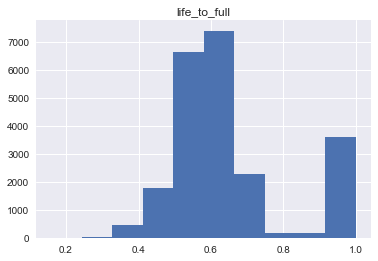

In [41]:
# most of the aparts have a life to full ratio of 60%

df[df.life_sq>0].hist('life_to_full')

In [42]:
test.loc[test.full_sq == 0,'full_sq'] = np.nan
test.loc[test.full_sq<test.life_sq,'full_sq'] = np.nan
test = test.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
test = test.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c343a50>]], dtype=object)

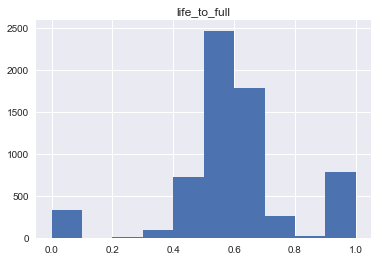

In [43]:
# Similiar to the uncleaned test datat
test.hist('life_to_full')

In [44]:
cols = ['price_doc','kremlin_km', 'full_sq','life_sq','life_to_full','floor', 'sub_area']
complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()

missingGroupsKrem = missing.groupby('kremlin_km')
missingGroupsSubArea = missing.groupby('sub_area')
for g in missingGroupsKrem:
    c = complete[complete.kremlin_km == g[0]]
    if len(c) < 1:
        c = complete[complete.sub_area == g[1].sub_area.unique().tolist()[0]]
    ratio = np.nanmedian(c.life_to_full)
    missing.loc[g[1].index,'life_sq'] = g[1].full_sq * ratio

### Kitch_sq
going to do the same for kitch_sq 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119056890>]], dtype=object)

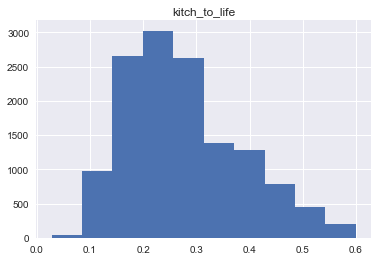

In [418]:
df[df.kitch_sq>0].hist('kitch_to_life')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1183c40d0>]], dtype=object)

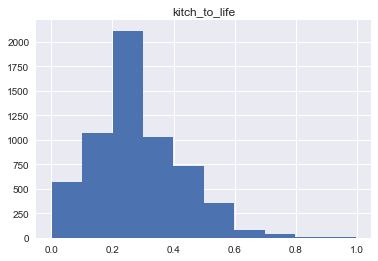

In [419]:
# distribution is about 20-30%
test[(test.kitch_to_life>0) & (test.kitch_to_life<1)].hist('kitch_to_life')

In [420]:
cols = ['price_doc','kremlin_km','life_sq','kitch_sq','kitch_to_life','floor', 'sub_area']
complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()

missingGroupsKrem = missing.groupby('kremlin_km')
missingGroupsSubArea = missing.groupby('sub_area')
for g in missingGroupsKrem:
    c = complete[complete.kremlin_km == g[0]]
    if len(c) < 1:
        c = complete[complete.sub_area == g[1].sub_area.unique().tolist()[0]]
    ratio = np.nanmedian(c.kitch_to_life)
    missing.loc[g[1].index,'kitch_sq'] = g[1].life_sq * ratio

In [421]:
cols = ['life_sq','kitch_sq','floor','max_floor']
df.loc[missing.index,cols] = missing.loc[:,cols]

In [422]:
## for all columns
# df.drop(['life_to_full', 'kitch_to_life', 'diff_full_life'],axis=1).to_csv('../input/clean_train_all_columns_chase.csv')

In [1]:
df.loc[(df.state.isnull() | (df.state==1)) & (df.product_type=='OwnerOccupier'),'state'] = np.nan
# bad.loc[:,'state'] = np.nan
# bad.loc[bad.build_year<=1972,'state'] = 1
# bad.loc[bad.build_year>1972,'state'] = 2
# bad.loc[bad.build_year>1983,'state'] = 3
# bad.loc[bad.build_year>1994,'state'] = 4
# df.loc[bad.index,'state'] = bad.state

NameError: name 'np' is not defined

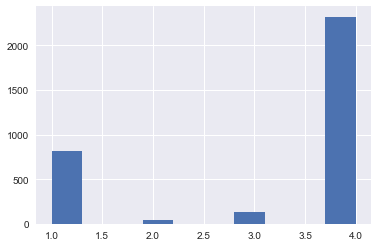

In [424]:
df[(df.product_type=='OwnerOccupier')].state.hist()

In [425]:
df.drop(df[df.full_sq.isnull()].index,axis=0,inplace=True)

df.drop(df[df.kitch_sq.isnull()].index, axis=0,inplace=True)


df.drop(df[df.floor.isnull()].index, axis=0,inplace=True)
df.drop(df[df.max_floor.isnull()].index, axis=0,inplace=True)
# df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

# cols = ['quarter','timestamp', 'price_doc', 'kremlin_km', 'full_sq', 'life_sq', 'floor',
#         'max_floor','sub_area', 'okurg_district']

df = df.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
df = df.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

In [468]:
df.loc[df.build_year < 1,'build_year'] = np.nan
bad_year = df[df.build_year.isnull()].copy()
bad_year.reset_index(inplace=True)
bad_year.build_year = bad_year.apply(lambda x: getKremlinGroupFloor(df,x['id']),axis=1)

In [469]:
df.loc[bad_year.id,'build_year'] = bad_year.build_year

In [470]:
df.to_csv('../data/clean_train_all_cols_chase.csv')

# drop all cols without atleast 28000 observations
# df.dropna(thresh=28000, axis=1,inplace=True)
# drop all rows with NANs


df.dropna(axis=1).to_csv('../data/clean_train_only_complete_cols_chase.csv')

In [471]:
sum(df.build_year > 2018)

0

In [427]:
np.nanmedian(raw_train.price_doc / raw_train.full_sq)

135294.11764705883

In [428]:
bad_year = df[df.build_year.isnull()]

In [430]:
bad_year.shape

(12943, 298)

In [431]:
bad_year.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

1975.0

In [374]:
df.price_full.median()

138254.17031463748

In [505]:
len(df[(df.price_full < 400000) & (df.price_full>75000)])

26448

### removing outliers based on price to sq meters

In [ ]:
df.shape

In [250]:
df[(df.price_full < 400000) & (df.price_full>75000)].to_csv('../data/clean_train_all_cols_outliers_removed_chase.csv')

# STOP HERE


<br>
<br>

### DIFFERENT DATA SET
this is something I'm playing with. Just trying different columns

In [ ]:
x.max

In [360]:
x = df[df.isnull().any(axis=1)].sum().to_frame()
x = df.isnull().sum()
x.sort_values()

columns = x[x<5000].index.tolist()

In [361]:
cols = columns[1:277]
cols.append('okurg_district')
cols.append('price_doc')
cols.append('timestamp')

In [362]:

temp = df[cols].copy()
temp = temp[~temp.isnull().any(axis=1)]

In [363]:
df_numeric = temp.select_dtypes(exclude=['object'])
df_obj = temp.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_all = pd.concat([df_numeric, df_obj], axis=1)

In [364]:
import sklearn.feature_selection as fs
select15 = fs.SelectKBest(fs.f_regression, k='all')
select15.fit_transform(df_all.drop(['price_doc','timestamp'],axis=1), df_all.price_doc)

array([[ 43.  ,  28.12,   4.  , ...,   0.  ,   0.  ,   0.  ],
       [ 34.  ,  19.  ,   3.  , ...,   0.  ,   1.  ,   1.  ],
       [ 43.  ,  29.  ,   2.  , ...,   0.  ,   2.  ,   2.  ],
       ..., 
       [ 86.  ,  59.  ,   3.  , ...,   0.  ,   2.  ,   4.  ],
       [ 64.  ,  32.  ,   5.  , ...,   0.  ,   3.  ,   9.  ],
       [ 43.  ,  28.  ,   1.  , ...,   0.  ,   2.  ,   5.  ]])

In [365]:
scores = pd.DataFrame(select15.scores_,cols[:-2],columns=["score"])
cols = scores[scores.score>500].index.tolist()
cols.append('floor')
cols.append('sub_area')
df_new = temp[cols].copy()

In [366]:
df_new.loc[:,'timestamp'] = df_all.timestamp.values
df_new.loc[:,'price_doc'] = df_all.price_doc.values

# df_new.to_csv('../Chase/data/clean_training_60_cols_chase.csv')

Timestamp('2011-08-20 00:00:00')

In [370]:
print df_new.columns.tolist()

['full_sq', 'life_sq', 'max_floor', 'kitch_sq', 'healthcare_centers_raion', '0_17_female', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'water_km', 'bulvar_ring_km', 'railroad_km', 'ID_railroad_terminal', 'radiation_km', 'stadium_km', 'detention_facility_km', 'workplaces_km', 'office_count_500', 'sport_count_500', 'cafe_count_1000_price_500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'cafe_count_1500', 'cafe_count_1500_price_500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'cafe_count_2000', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'cafe_count_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_pr

# REALLY STOP HERE
everything else is old

# Missing Build Year

In [228]:
add_multiples(df)

In [229]:
df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

In [230]:
dfg = df.loc[:,['quarter','okurg_district','price_full']].groupby('okurg_district')

In [231]:
md = dfg.aggregate(np.nanmedian)

In [232]:
x = np.log(df.price_doc)
y = np.log(df.price_doc + 1)

In [233]:
print(x[0:10])
print(y[0:10])

id
7675    16.128046
8138    16.012735
8156    15.763069
8157    15.775605
8171    15.243067
8178    15.679591
8258    16.308716
8285    15.856731
8290    16.275099
8296    14.285514
Name: price_doc, dtype: float64
id
7675    16.128046
8138    16.012735
8156    15.763069
8157    15.775605
8171    15.243067
8178    15.679591
8258    16.308716
8285    15.856731
8290    16.275099
8296    14.285515
Name: price_doc, dtype: float64


In [234]:
add_multiples(df)

In [235]:
df.sort_values('price_full_std',ascending=False).head()

,timestamp,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,life_to_full,kitch_to_life,diff_full_life,price_full,price_full_std,quarter
id,,,,,,,,,,,,,,,,,,,,
16102,2014-03-17,65000000,3.328401,120.0,63.0,17.0,15.0,20.0,2002.0,3.0,4.0,4.0,Hamovniki,Central,0.525000,0.269841,57.0,541666.666667,6.909713,Q1-14
11088,2013-10-08,71200000,10.685592,132.0,76.0,12.0,16.0,28.0,2006.0,4.0,NaN,4.0,Prospekt Vernadskogo,Western,0.575758,0.157895,56.0,539393.939394,6.869888,Q4-13
15811,2014-03-06,17700000,1.354750,39.0,28.0,6.0,4.0,6.0,1931.0,2.0,4.0,2.0,Hamovniki,Central,0.717949,0.214286,11.0,453846.153846,5.370852,Q1-14
17175,2014-04-09,14000000,2.301970,31.0,17.0,6.0,9.0,12.0,1954.0,1.0,3.0,2.0,Arbat,Central,0.548387,0.352941,14.0,451612.903226,5.331719,Q2-14
22697,2014-09-19,55000000,1.730353,125.0,67.0,9.0,7.0,9.0,1990.0,4.0,3.0,2.0,Tverskoe,Central,0.536000,0.134328,58.0,440000.000000,5.128229,Q3-14


In [178]:
bad_sq = df.query('full_sq < life_sq or life_sq < kitch_sq or full_sq.isnull()')

In [929]:
# change all full and life <= 10 to NaN
df.loc[df.full_sq < 10,'full_sq'] = np.nan
df.loc[df.life_sq < 10,['life_sq','kitch_sq']] = np.nan

df.loc[(df.kitch_sq >= df.life_sq), 'kitch_sq'] = np.nan
df.loc[(df.kitch_sq >= df.full_sq),'kitch_sq'] = np.nan

In [930]:
# remove the rows that don't have either full_sq or life_sq
bad = df[(df.full_sq.isnull())& (df.life_sq.isnull())]
df.drop(bad.index, axis=0, inplace=True)

dropped.extend(bad.index)


### Square Meter (full_sq, life_sq, kitch_sq)

Added price to square meters columns to help identify outliers
#### Adjustments
    * full and life < 10 are set to np.nan (10 is about a 100 sq foot apt)
    * full < life check to see which one appears to be the incorrect value based on price multiples stds.

kitchens with 0 or 1 maybe studio apts

In [931]:
df.sort_values('full_sq', ascending=False).head()

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3530,6868818,16.139809,5326.0,22.0,NaN,13.0,NaN,NaN,NaN,NaN,0.780191,0.499398,0.699257,NaN,4.907833,2.149384,Birjulevo Vostochnoe,0.214503,28.439791,0.228109,0.841827,3.381655,2012-09-07,Southern,1289.676680,312219.000000,NaN,NaN,0.004131,NaN
2783,13250000,12.307897,729.0,44.0,NaN,12.0,NaN,NaN,NaN,NaN,0.136485,0.023740,0.426871,NaN,2.685885,0.564859,Troparevo-Nikulino,1.415226,22.127146,0.119978,1.383085,2.488351,2012-07-06,Western,18175.582990,301136.363636,NaN,NaN,0.060357,NaN
22788,4725142,0.072897,637.0,637.0,10.0,18.0,19.0,2016.0,2.0,1.0,1.048962,0.189089,0.269716,4.0,1.482746,2.608162,Tverskoe,2.640803,13.459068,0.326035,2.566044,1.421099,2014-09-23,Central,7417.805338,7417.805338,NaN,NaN,1.000000,0.015699
18344,6213200,20.549464,634.0,NaN,0.0,3.0,17.0,NaN,2.0,NaN,0.286711,0.017572,0.214197,1.0,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2014-05-13,South Eastern,9800.000000,NaN,NaN,NaN,NaN,NaN
5947,10200000,16.292579,634.0,38.0,NaN,3.0,NaN,NaN,NaN,NaN,0.025172,0.121641,0.353390,NaN,1.746993,1.566321,Lianozovo,1.063524,8.067791,0.204624,1.426593,2.029415,2013-02-07,North Eastern,16088.328076,268421.052632,NaN,NaN,0.059937,NaN


In [932]:
# changed the max to 53
df.loc[3530,'full_sq'] = 53

In [934]:
df.sort_values('price_to_full',ascending=False).head()

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16102,65000000,3.328401,120.0,63.0,17.0,15.0,20.0,2002.0,3.0,4.0,0.367275,0.038431,0.438905,4.0,1.365098,0.951508,Hamovniki,1.450669,4.670340,0.156870,1.032216,1.398559,2014-03-17,Central,541666.666667,1.031746e+06,7.441133,7.064074,0.525000,0.269841
11088,71200000,10.685592,132.0,76.0,12.0,16.0,28.0,2006.0,4.0,NaN,0.482608,0.300011,0.307083,4.0,2.474512,1.186187,Prospekt Vernadskogo,2.282690,15.060547,0.250839,2.005483,0.452202,2013-10-08,Western,539393.939394,9.368421e+05,7.399770,6.225587,0.575758,0.157895
24859,53787140,4.190635,101.0,NaN,0.0,15.0,0.0,NaN,2.0,NaN,0.151933,0.123367,0.495513,4.0,1.498269,2.091276,Donskoe,1.216591,11.697905,0.038747,1.215073,1.336556,2014-11-18,Southern,532545.940594,NaN,7.275139,NaN,NaN,NaN
7460,91066096,7.424229,185.0,66.0,NaN,33.0,NaN,NaN,NaN,NaN,0.543921,0.123274,0.883583,NaN,3.721862,1.491677,Ramenki,0.858441,30.224681,0.379486,0.920536,0.485134,2013-04-19,Western,492249.167568,1.379789e+06,6.541751,10.139075,0.356757,NaN
3560,77000000,3.477546,157.0,89.0,NaN,15.0,NaN,NaN,NaN,NaN,0.191674,0.344225,1.072453,NaN,1.244796,1.189904,Mar'ina Roshha,0.529682,11.417722,0.234259,1.220031,1.023092,2012-09-10,North Eastern,490445.859873,8.651685e+05,6.508932,5.592343,0.566879,NaN


#### Checking life_sq for possible wrong inputs

In [935]:
off = df[df.full_sq < df.life_sq].sort_values('life_sq', ascending=False)[0:15]
# off

In [936]:
# these appear to be off a digit 
off_index = off[0:13].index
if impute:
    df.loc[13549,'life_sq'] = df.loc[13549,'life_sq'] / 10 # off two digits
    df.loc[off_index,'life_sq'] = df.loc[off_index,'life_sq']/10
else:
    df.loc[off_index,'life_sq'] = np.nan

In [937]:
# df.loc[off.index,:]

### Full vs Life
when full < life, take the one that seems like less of an outlier 

In [938]:
bad_df = df[df.full_sq < df.life_sq]
print "number of rows " , len(bad_df)
bad_df.head()

number of rows  17


,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1825,5200000,13.635361,18.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,0.228476,0.075926,0.313596,NaN,2.334253,1.624978,Ljublino,1.083078,21.636236,0.103915,2.416847,3.217099,2012-04-09,South Eastern,288888.888889,136842.105263,2.840665,-0.842502,NaN,NaN
6534,13801229,13.143751,80.0,88.0,NaN,9.0,NaN,NaN,NaN,NaN,1.424717,0.646005,0.510474,NaN,3.405352,0.742342,Pokrovskoe Streshnevo,0.443602,27.479760,0.110209,0.713374,3.781754,2013-03-15,North Western,172515.362500,156832.147727,0.722707,-0.665888,NaN,NaN
6996,6290256,20.549464,73.0,77.0,NaN,10.0,NaN,NaN,NaN,NaN,0.286711,0.017572,0.214197,NaN,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2013-04-03,South Eastern,86167.890411,81691.636364,-0.848787,-1.329762,NaN,NaN
8104,3622465,20.549464,37.0,38.0,NaN,8.0,NaN,NaN,NaN,NaN,0.286711,0.017572,0.214197,NaN,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2013-05-23,South Eastern,97904.459459,95328.026316,-0.635186,-1.209283,NaN,NaN
9485,3000000,13.687390,52.0,53.0,8.0,12.0,1.0,1983.0,2.0,3.0,0.194483,0.030993,0.298627,1.0,3.198813,2.625650,Juzhnoe Medvedkovo,0.484628,25.427899,0.137156,0.659250,5.202360,2013-07-27,North Eastern,57692.307692,56603.773585,-1.367033,-1.551417,NaN,0.150943


In [939]:
sum(df.full_sq.isnull())

7

## Life_sq > Full_sq???
select the one that seems like the least of an outlier based on price to sq

In [940]:
# select full and np.nan life if price to full is more reasonable
full_ind = bad_df[abs(bad_df.price_to_full_std) < abs(bad_df.price_to_life_std)].index

# select life and np.nan full if price to full is more reasonable
life_ind = [x for x in bad_df.index if x not in full_ind]

df.loc[full_ind, 'life_sq'] = np.nan
df.loc[life_ind, 'full_sq'] = np.nan


# updating multiples
add_multiples(df)

In [941]:
# df[df.life_sq.isnull()]

#### Characteristics by Neighborhood
Grouped the data by subset and will take the median neighborhood ratios of sq meters to impute missingness

In [942]:
df.loc[[27398,30446],:]

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27398,6489774,16.957155,62.0,NaN,NaN,13.0,17.0,NaN,2.0,1.0,0.230087,0.360319,0.044599,1.0,3.343157,1.242741,Solncevo,0.631064,24.450869,0.257288,0.874445,2.128289,2015-01-21,Western,104673.774194,NaN,-0.511887,NaN,NaN,NaN
30446,7567425,16.957155,79.0,NaN,NaN,17.0,17.0,NaN,3.0,1.0,0.230087,0.360319,0.044599,1.0,3.343157,1.242741,Solncevo,0.631064,24.450869,0.257288,0.874445,2.128289,2015-06-27,Western,95790.189873,NaN,-0.673618,NaN,NaN,NaN


In [943]:
dfg = df.groupby('sub_area')
life_full_dict = dfg['life_to_full'].aggregate('median').to_dict()
kitch_life_dict = dfg['kitch_to_life'].aggregate('median').to_dict()

In [944]:
# impute the missing sq by using the sub areas 

mis_full_index = df[df.full_sq.isnull()].index
mis_life_index = df[df.life_sq.isnull()].index
mis_kitch_index = df[df.kitch_sq.isnull() | (df.kitch_sq > df.life_sq)].index

if impute:
    # update the life_to_full ratio from median of subareas
    df.loc[mis_full_index,'life_to_full'] = [life_full_dict[x] for x in df.loc[mis_full_index,'sub_area']]
    df.loc[mis_life_index,'life_to_full'] = [life_full_dict[x] for x in df.loc[mis_life_index,'sub_area']]
    df.loc[mis_kitch_index,'kitch_to_life'] = [kitch_life_dict[x] for x in df.loc[mis_kitch_index,'sub_area']]
    
    # impute sq based off of ratio
    df.loc[mis_full_index,:] = df.loc[mis_full_index,:].assign(full_sq = lambda x: x.life_sq / x.life_to_full)
    df.loc[mis_life_index,:] = df.loc[mis_life_index,:].assign(life_sq = lambda x: x.full_sq * x.life_to_full)
    df.loc[mis_kitch_index,:] = df.loc[mis_kitch_index,:].assign(kitch_sq = lambda x: x.life_sq * x.kitch_to_life)

In [945]:
add_multiples(df)

### Building characteristics
Imputations: 
    Years = change every build year less than 1875 to 1875

In [947]:
if impute:
    df.loc[df.build_year < 1875, 'build_year'] = 1875
    df.loc[df.build_year==1, 'build_year'] = 2001
    df.loc[df.build_year==3, 'build_year'] = 2003
    df.loc[df.build_year==20, 'build_year'] = 2000
    df.loc[df.build_year==71, 'build_year'] = 1971
    df.loc[df.build_year==215, 'build_year'] = 2015
    df.loc[15223,'build_year'] = 1965
    df.loc[10092,'build_year'] = 2005
    df.loc[10093,'build_year'] = 2009

#### If max floor is nan
try a random sample from first the group by distance else the DF set

In [983]:
bad = df[df.max_floor.isnull()].index
if impute:
    df.loc[bad,"max_floor"] = [imputeMaxFloor(x) for x in bad]

In [989]:
np.random.randint(15)

8

In [991]:
bad = df[df.floor.isnull()].index
if impute:
    df.loc[bad,'floor'] = [np.random.randint(df.loc[x,'max_floor']) for x in bad]

### Looking at missing year
first see if it matches any other buildings by max_floor in the dist group

In [42]:
df.head()

,timestamp,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,life_to_full,kitch_to_life,diff_full_life
id,,,,,,,,,,,,,,,,,
1,2011-08-20,5850000,15.156211,43.0,27.0,NaN,4.0,5.0,NaN,NaN,NaN,NaN,Bibirevo,North Eastern,0.627907,NaN,16.0
2,2011-08-23,6000000,8.698054,34.0,19.0,NaN,3.0,9.0,NaN,NaN,NaN,NaN,Nagatinskij Zaton,Southern,0.558824,NaN,15.0
3,2011-08-27,5700000,9.067885,43.0,29.0,NaN,2.0,5.0,NaN,NaN,NaN,NaN,Tekstil'shhiki,South Eastern,0.674419,NaN,14.0
4,2011-09-01,13100000,19.487005,89.0,50.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,Mitino,North Western,0.561798,NaN,39.0
5,2011-09-05,16331452,2.578671,77.0,77.0,NaN,4.0,8.0,NaN,NaN,NaN,NaN,Basmannoe,Central,1.000000,NaN,0.0


In [1219]:
ms_distances = missing.kremlin_km.unique()

In [1262]:
for d in ms_distances:
    c = complete[complete.kremlin_km == d]
    
    # check to make sure there are enough observations in the complete group, if not use total complete
    if len(c) < 3:
        c = complete
    m = missing[missing.kremlin_km == d]
    n = int(math.sqrt(len(c)))

    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(c.drop('floor', axis=1),c.floor)
        
    missing.loc[m.index,'floor'] = neigh.predict(m.drop('floor', axis=1))


In [1266]:
if impute:
    df.loc[missing.index,'floor'] = missing.floor